In [1]:
from modules import *
from functions import *

import matplotlib.patches as patches
import matplotlib.transforms as transforms
import matplotlib.gridspec as gridspec

plt.rcParams['svg.fonttype'] = 'none'  # Ensure text is editable in Illustrator

In [38]:
# Parameters

N = int(500)                                                        # Number of neurons
a = 10                                                              # Parameters for propensity function
theta_stim = 90                                                     # Angle to stimulate at 
n_test_angles = 100                                                 # Number of angles to use to test for preferred orientation
vars = np.random.lognormal(2, 0.6, N)                               # Width of each neuron's tuning curve
learning_rate = 0.01                                                # Learning rate

n_days = 28                                                         # Number of days to run for
n_norm_per_day = 1                                                  # How many times to normalise the weights per day
n_steps_per_norm = 50 # 30                                             # How many orientation stimuli per day                    *** Increase this (and decrease learning rate respectively) to simulate more visual experience per day. Note: will take longer to run ***
n_steps = n_steps_per_norm * n_norm_per_day * n_days                # Number of steps to run for
init_steps = 300                                                    # Number of trials to run to settle to a baseline

hebb_scaling = 0.3                                                  # Scaling of Hebbian component
rand_scaling = 1                                                    # Scaling of random component 

# Initialisation

W_init = initialise_W(N, vars)                                                                                                      # Initialise weights 
W_baseline = prerun(W_init, theta_stim, a, hebb_scaling, rand_scaling, learning_rate, n_steps_per_norm, init_steps)                 # Settle to a baseline

POs = []; ratios = []
W = np.zeros((N, N, n_steps+1), dtype=np.float32)                                                                                   # Initialise weight matrix
W[:, :, 0] = W_baseline
W_per_day = np.zeros((N, N, n_days))

# Run trials

for t in tqdm(range(n_steps)):
    W_old = W[:, :, t]
    u = circular_gaussian(N, theta_stim, amp=0.62, sigma=60, baseline=0)
    v = W_old.T.dot(u)
    H = np.outer(u, v)                                                                           # Hebbian component - outer product of input and output                                  
    eta = np.random.randn(N, N)                                                                  # Random component - sample from normal distribution
    prop_function = propensity(W_old, a)                                                         # Propensity function - tanh(w)
    hebb =  hebb_scaling * H                                                                     # Scaled Hebbian component 
    rand =  rand_scaling * eta                                                                   # Scaled random component
    W_new = W_old + learning_rate * prop_function * (hebb + rand)                                # Update weights

    if t % n_steps_per_norm == 0:                                                                # Perform normalisation after every N_theta steps 
        normalisation(W_new)
        if t % (n_steps_per_norm * n_norm_per_day) == 0:                                         # Save weights and preferred orientations every day 
            W_per_day[:, :, t // (n_steps_per_norm * n_norm_per_day)] = W_new                    
            PO = get_preferred_orientations(N, W_new, n_angles=n_test_angles); POs.append(PO)    
            ratios.append(np.mean(abs(hebb)) / (np.mean(abs(rand)) + 10e-10))

    W[:, :, t+1] = W_new

preferences = np.array(POs).T 
initial_preferences = np.linspace(0, 180, N) 
final_preferences = preferences[:, -1]
absolute_change = np.array([circular_distance(preferences[:, day], initial_preferences) for day in range(n_days)])
median_change_per_day = np.median(absolute_change, axis=1)   
std_change_per_day = np.std(absolute_change, axis=1)  

100%|██████████| 1400/1400 [00:20<00:00, 66.86it/s]


In [39]:
W_start = W[:, :, 0]
W_end = W[:, :, -1]
W_avg = np.mean(W, axis=2)
v_start = W_start.T.dot(u)
v_end = W_end.T.dot(u)
v_avg = W_avg.T.dot(u)

H_start = np.outer(u, v_start)
H_end = np.outer(u, v_end)
H_avg = np.outer(u, v_avg)

H_contr_start = hebb_scaling * propensity(W_start, a) * H_start
H_contr_end = hebb_scaling * propensity(W_end, a) * H_end
H_contr_avg = hebb_scaling * propensity(W_avg, a) * H_avg


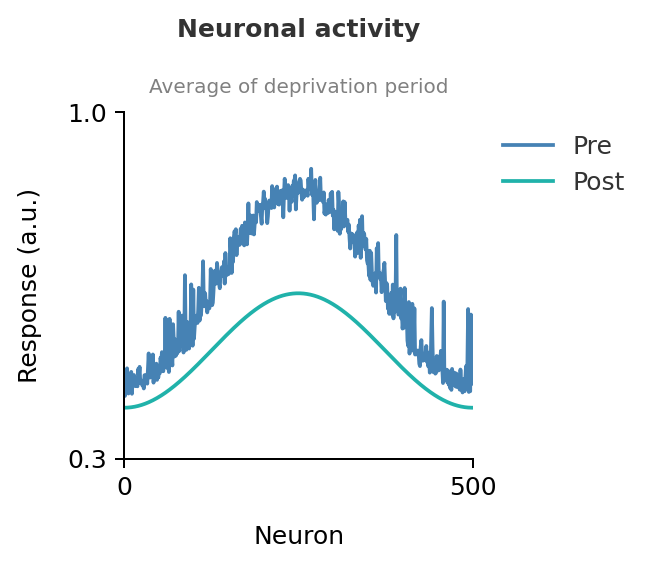

In [40]:

fig = plt.figure(figsize=(2.5, 2.5), dpi=180)

plt.plot(v_avg, c='steelblue', alpha=1, label='Pre')
plt.plot(u, c='lightseagreen', label='Post')
# plt.plot(v_end, c='firebrick', alpha=0.8, label='Post end')

plt.xticks([0, N])
plt.yticks([0.3, 1])
plt.ylim(0.3, 1)
plt.xlabel('Neuron')
plt.ylabel('Response (a.u.)')
plt.locator_params(axis='y', nbins=4)

plt.title(r'Neuronal activity', fontweight='bold', fontsize=10, pad=30)
plt.text(N/2, 1.05, 'Average of deprivation period', ha='center', va='center', fontsize=8, color='grey')

plt.legend(frameon=False, loc='upper right', bbox_to_anchor=(1.5, 1))

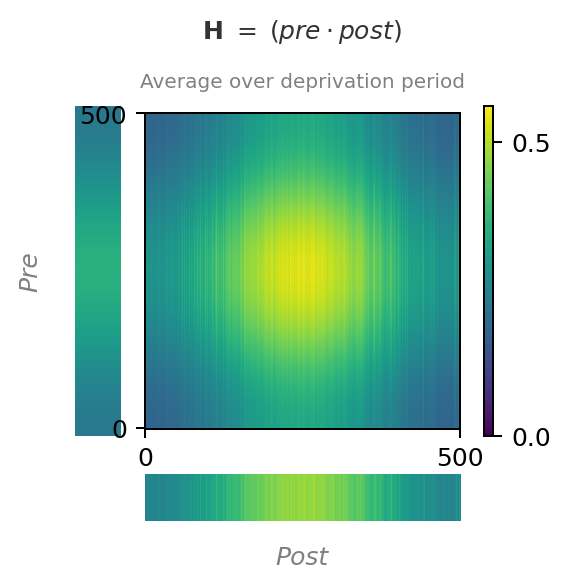

In [41]:
fig = plt.figure(figsize=(3, 3), dpi=180)

gs = gridspec.GridSpec(2, 3, width_ratios=[1, 7, 0.2], height_ratios=[7, 1])

ax0 = plt.subplot(gs[0])
ax0.imshow(u.reshape(-1, 1), cmap='viridis', aspect='auto', vmin=0, vmax=1)
ax0.axis('off')

ax1 = plt.subplot(gs[1]) #, sharey=ax0)
im = ax1.imshow(H_avg, cmap='viridis', aspect='equal', vmin=0)
ax1.set_xticks([0, N])
ax1.set_yticks([0, N])
ax1.set_xlabel('Post', fontstyle='italic', c='grey', labelpad=30)
ax1.set_ylabel('Pre', fontstyle='italic', c='grey', labelpad=15)
ax1.set_title(r'H $ = \; (pre \cdot post)$', fontweight='bold', fontsize=10, pad=30)
ax1.text(N/2, N + 50, 'Average over deprivation period', ha='center', va='center', fontsize=8, color='grey')
ax1.invert_yaxis()

ax2 = plt.subplot(gs[4]) #, sharex=ax1)
im2 = ax2.imshow(v_avg.reshape(1, -1), cmap='viridis', aspect='auto', vmin=0, vmax=1)
ax2.axis('off')

ax3 = plt.subplot(gs[2])
plt.colorbar(im, cax=ax3, ticks=[0, 0.5])

sns.despine(right=False, top=False)

# save as svg 
# plt.savefig('figures/rebuttal_model_1.svg', format='svg', bbox_inches='tight')


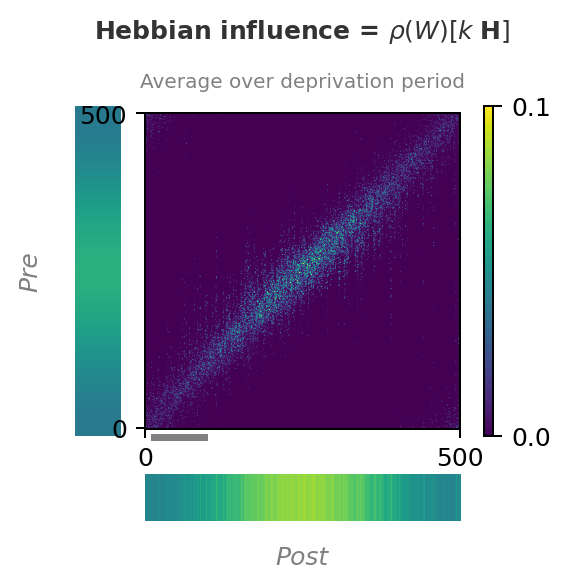

In [42]:
fig = plt.figure(figsize=(3, 3), dpi=180)

gs = gridspec.GridSpec(2, 3, width_ratios=[1, 7, 0.2], height_ratios=[7, 1])

ax0 = plt.subplot(gs[0])
ax0.imshow(u.reshape(-1, 1), cmap='viridis', aspect='auto', vmin=0, vmax=1)
ax0.axis('off')

ax1 = plt.subplot(gs[1]) #, sharey=ax0)
im = ax1.imshow(H_contr_avg, cmap='viridis', aspect='equal', vmin=0, vmax=0.1)
ax1.set_xticks([0, N])
ax1.set_yticks([0, N])
ax1.set_xlabel('Post', fontstyle='italic', c='grey', labelpad=30)
ax1.set_ylabel('Pre', fontstyle='italic', c='grey', labelpad=15)
ax1.set_title(r'Hebbian influence = $\rho({W}) \left[ k \; \mathbf{H} \right] $', fontweight='bold', fontsize=10, pad=30)
ax1.text(N/2, N + 50, 'Average over deprivation period', ha='center', va='center', fontsize=8, color='grey')
ax1.invert_yaxis()

sample_start = 10
sample_end = 100
rect = patches.Rectangle((sample_start, -20), (sample_end - sample_start), 10, linewidth=1, edgecolor='none', facecolor='k', alpha=0.5, clip_on=False)
ax1.add_patch(rect)

ax2 = plt.subplot(gs[4]) 
ax2.imshow(v_avg.reshape(1, -1), cmap='viridis', aspect='auto', vmin=0, vmax=1)
ax2.axis('off')

ax3 = plt.subplot(gs[2])
plt.colorbar(im, cax=ax3, ticks=[0, 0.1])

sns.despine(right=False, top=False)

# plt.savefig('figures/rebuttal_model_2.svg', format='svg', bbox_inches='tight')



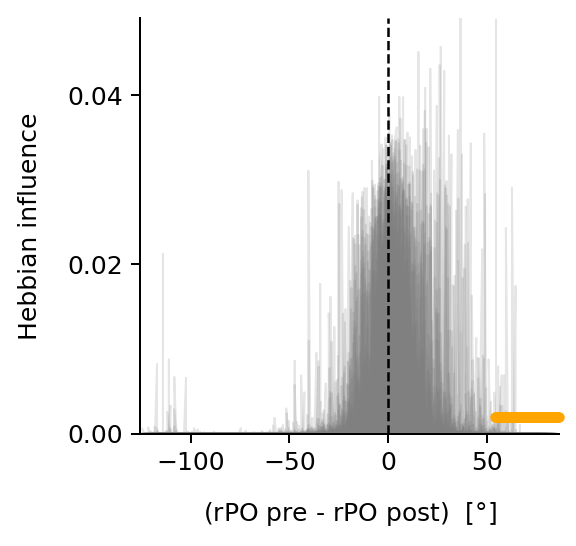

In [43]:
post_relative_PO_indices = (np.arange(sample_start, sample_end) / N * 180 - 90).astype(int)    # -86 to -54
pre_relative_PO_indices = (np.arange(0, N) / N * 180 - 90).astype(int)                         # -90 to 90

fig, ax = plt.subplots(figsize=(3, 3), dpi=180)

theta_stim_range = np.zeros(N)

for i in np.arange(sample_start, sample_end):
    ax.plot(pre_relative_PO_indices - (i / N * 180 - 90) - 90, np.roll(H_contr_avg[:, i], 250)*0.5, alpha=0.2, lw=0.8, c='gray')
    theta_stim_range[i] = 0 - (i / N * 180 - 90)
    ax.scatter(0 - (i / N * 180 - 90), 0.002, c='orange', s=10, zorder=10, clip_on=False)

ax.set_ylabel('Hebbian influence')
ax.axvline(0, c='k', ls='--', lw=1, label='Initial tuning curve centre')
ax.set_xlabel(r'(rPO pre - rPO post)  $[\degree]$')
ax.locator_params(axis='y', nbins=4)

# plt.savefig('figures/rebuttal_model_3.svg', format='svg', bbox_inches='tight')

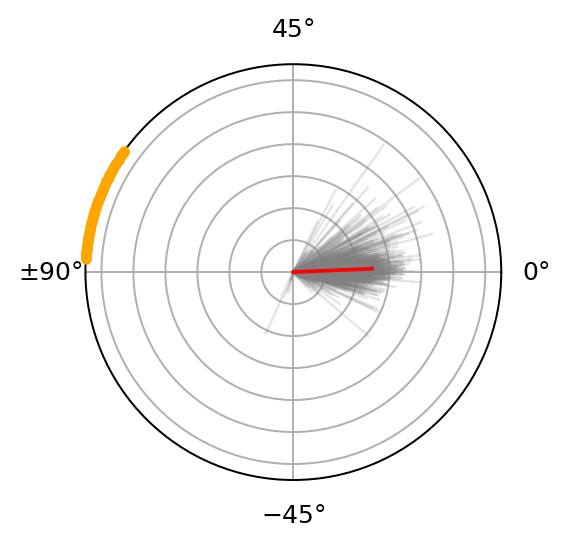

In [44]:
# Create a polar subplot
fig, ax = plt.subplots(figsize=(3, 3), dpi=180, subplot_kw={'projection': 'polar'})

# Calculate the x and y values and plot them
for i in np.arange(sample_start, sample_end):
    x = np.radians(pre_relative_PO_indices - (i / N * 180 - 90) - 90)
    y = np.roll(H_contr_avg[:, i], 250)
    ax.plot(x, y, alpha=0.2, lw=0.8, c='gray')

    x1 = np.radians(theta_stim_range[i] + 90)
    y1 = 0.13
    ax.scatter(x1, y1, c='orange', s=10, zorder=10, clip_on=False)

ax.set_yticklabels([])

# Calculate the circular mean
x_values = np.concatenate([np.radians(pre_relative_PO_indices - (i / N * 180 - 90) - 90) for i in np.arange(sample_start, sample_end)])
y_values = np.concatenate([np.roll(H_contr_avg[:, i], 250)*0.5 for i in np.arange(sample_start, sample_end)])
angles = np.arctan2(y_values, x_values)
mean_angle = np.arctan2(np.mean(np.sin(angles)), np.mean(np.cos(angles)))

# Plot a line showing the circular mean
ax.plot([0, np.pi - mean_angle], [0, np.max(y_values)], color='red')

# rename x-axis from 0 to 180
ax.set_xticks(np.radians([0, 90, 180, 270]))
ax.set_xticklabels([r'$0 \degree$', r'$45 \degree$', r'$\pm 90 \degree$', r'$-45 \degree$']);

# plt.savefig('figures/rebuttal_model_3_polar.svg', format='svg', bbox_inches='tight')


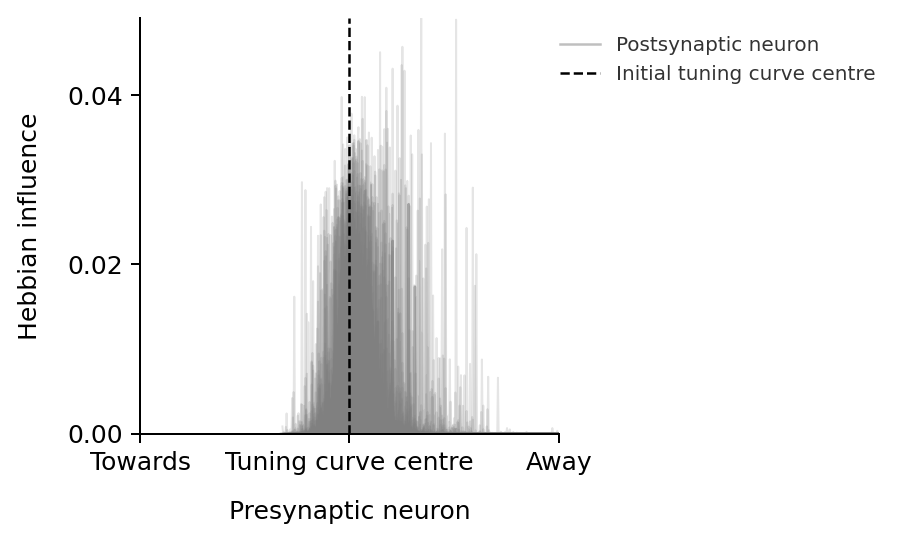

In [45]:
fig, ax = plt.subplots(figsize=(3, 3), dpi=180)

for i in range(sample_start, sample_end):
    ax.plot(np.arange(0, N)-i, H_contr_avg[:, i]*0.5, alpha=0.2, lw=0.8, c='gray')
    if i == sample_start:
        ax.plot(np.arange(0, N)-i, H_contr_avg[:, i]*0.5, alpha=0.5, lw=1, c='gray', label='Postsynaptic neuron')

ax.axvline(0, c='k', ls='--', lw=1, label='Initial tuning curve centre')
ax.set_xlim(-300, 300)
ax.set_xticks([-300, 0, 300])
ax.set_xticklabels(['Towards', 'Tuning curve centre', 'Away'], fontsize=10, color='k', rotation=0)

ax.set_ylabel('Hebbian influence')
ax.set_xlabel('Presynaptic neuron')
ax.locator_params(axis='y', nbins=4)
ax.legend(frameon=False, loc='upper right', bbox_to_anchor=(1.8, 1), fontsize=8)

# plt.savefig('figures/rebuttal_model_3.svg', format='svg', bbox_inches='tight')